# EX10 Rock Scissor Paper  
###### 온라인 코어 2기 박수경

이번 과제에서는 가위, 바위, 보를 분류할 줄 아는 모델을 만들어보기로 한다. 딥러닝 기술을 구현할 때 다음과 같은 기본적인 순서를 따를 수 있다.  

 - 데이터 준비 → 딥러닝 네트워크 설계 → 학습 → 테스트(평가)  
 
기본적으로 사용할 라이브러리들을 import 한다.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os

### 데이터 준비

데이터를 불러와서 resizing 한다. teachable machine에서 웹캠으로 데이터를 만들었는데, 그 사진의 사이즈는 224\*224 여서 28\*28로 바꾸어준다.  
크기 변환을 위해 PIL 라이브러리를 불러온다. PIL(pillow)은 파이썬의 이미지 처리 라이브러리로, 이미지의 다양한 처리에 필요한 기능을 제공한다. (참고: https://ddolcat.tistory.com/690)  
가위, 바위, 보 각각의 데이터들을 resizing한다. 

In [3]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_s = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path_s)

print("가위 이미지 resize 완료!")

464  images to be resized.
464  images resized.
가위 이미지 resize 완료!


In [5]:
image_dir_path_r = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path_r)

print("바위 이미지 resize 완료!")

466  images to be resized.
466  images resized.
바위 이미지 resize 완료!


In [6]:
image_dir_path_p = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path_p)

print("보 이미지 resize 완료!")

460  images to be resized.
460  images resized.
보 이미지 resize 완료!


사진을 데이터로 읽어들이는 함수인 load_data()를 정의하고 사진을 읽어들인다. load_data() 함수를 통해 각각의 폴더의 사진의 레이블을 지정해 데이터로 저장할 수 있다.

In [7]:
import numpy as np

def load_data(img_path, number_of_data=1390):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("전체 학습데이터(x_full_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_full_train, y_full_train)=load_data(image_dir_path)
x_train_norm = x_full_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_full_train shape: {}".format(x_full_train.shape))
print("y_full_train shape: {}".format(y_full_train.shape))

전체 학습데이터(x_full_train)의 이미지 개수는 1390 입니다.
x_full_train shape: (1390, 28, 28, 3)
y_full_train shape: (1390,)


첫번째 이미지를 불러와 본다. 잘 불러와 진 것을 확인할 수 있다. 

라벨:  0


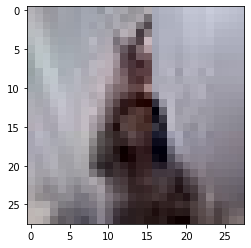

In [8]:
plt.imshow(x_full_train[0])
print('라벨: ', y_full_train[0])

### 딥러닝 네트워크 설계

가위바위보 데이터셋은 MNIST 데이터셋처럼 흑백 이미지가 아니라 3색, 즉 3개의 채널을 가지고 있다. 따라서 `input_shape=(28,28,3)`로 작성한다. 마지막으로 분류해야 하는 클래스도 가위, 바위, 보 세 가지 이다. 따라서 마지막 층의 unit 도 3으로 작성했다. 다중 분류이므로 마지막층의 활성화함수는 `softmax` 로 작성하였다.

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model =keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (No

### 딥러닝 네트워크 학습시키기

우리가 가져온 학습 데이터에서 일부를 검증용 데이터로 떼어 두려고 한다. x_train_norm 과 y_full_train 을 적절하게 스플릿한다. 트레인 셋의 20%정도를 검증용 데이터로 만든다.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(x_train_norm, y_full_train, test_size= 0.20, shuffle=True, random_state=1004)

In [12]:
y_val

array([1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 1, 2,
       0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 0, 1, 0,
       2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2, 0, 2, 2, 0,
       0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1,
       2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1,
       2, 2, 0, 1, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 0, 0, 0,
       1, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2,
       2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1,
       2, 1, 0, 0, 0, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 2, 0,
       0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1], dtype=int32)

In [13]:
model.compile(optimizer='Adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(
      X_train, y_train, epochs=15, batch_size =32,
    validation_data=(X_val, y_val))

Epoch 1/15
35/35 [==============================] - 3s 12ms/step - loss: 0.9633 - accuracy: 0.6043 - val_loss: 0.7219 - val_accuracy: 0.8345
Epoch 2/15
35/35 [==============================] - 0s 4ms/step - loss: 0.4679 - accuracy: 0.8768 - val_loss: 0.2623 - val_accuracy: 0.9209
Epoch 3/15
35/35 [==============================] - 0s 4ms/step - loss: 0.2035 - accuracy: 0.9415 - val_loss: 0.1589 - val_accuracy: 0.9353
Epoch 4/15
35/35 [==============================] - 0s 4ms/step - loss: 0.1159 - accuracy: 0.9622 - val_loss: 0.1012 - val_accuracy: 0.9712
Epoch 5/15
35/35 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9757 - val_loss: 0.0775 - val_accuracy: 0.9784
Epoch 6/15
35/35 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9730 - val_loss: 0.0764 - val_accuracy: 0.9676
Epoch 7/15
35/35 [==============================] - 0s 4ms/step - loss: 0.0439 - accuracy: 0.9892 - val_loss: 0.0427 - val_accuracy: 0.9964
Epoch 8/15
35/35 [=

In [14]:
!free -mh #현재 사용하고 있는 메모리 중간 체크

              total        used        free      shared  buff/cache   available
Mem:           17Gi       3.0Gi       9.5Gi        15Mi       5.1Gi        14Gi
Swap:            0B          0B          0B


In [15]:
history.history

{'loss': [0.9633346796035767,
  0.4678713083267212,
  0.20349806547164917,
  0.11591672897338867,
  0.0823383778333664,
  0.07862767577171326,
  0.0439118891954422,
  0.03459978476166725,
  0.038307640701532364,
  0.023537851870059967,
  0.017032315954566002,
  0.015339060686528683,
  0.010779677890241146,
  0.007937328889966011,
  0.007654647342860699],
 'accuracy': [0.6043165326118469,
  0.8767985701560974,
  0.9415467381477356,
  0.9622302055358887,
  0.9757194519042969,
  0.9730215668678284,
  0.9892086386680603,
  0.9937050342559814,
  0.9856114983558655,
  0.9973021745681763,
  0.9982014298439026,
  0.9982014298439026,
  0.9991007447242737,
  1.0,
  1.0],
 'val_loss': [0.7218984961509705,
  0.2622710168361664,
  0.15892252326011658,
  0.10123453289270401,
  0.07751379907131195,
  0.07641119509935379,
  0.04270124435424805,
  0.05433880537748337,
  0.028273047879338264,
  0.030772730708122253,
  0.04476180300116539,
  0.017541242763400078,
  0.015436366200447083,
  0.0122430501505

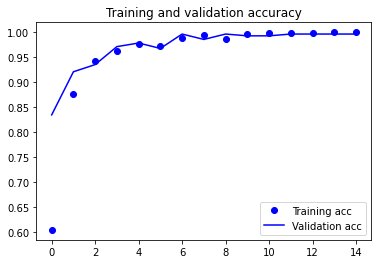

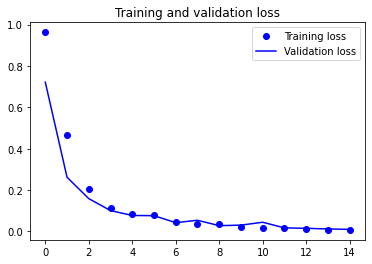

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 모델 테스트

다른 사람의 가위바위보 이미지를 가져와 test 데이터로 삼는다.

In [17]:
test_scissor_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_28/scissor"
resize_images(test_scissor_image_dir_path)   # 테스트 가위 이미지 resize
print("테스트용 가위 이미지 resize 완료!", '\n')

test_rock_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_28/rock"
resize_images(test_rock_image_dir_path)   # 테스트 바위 이미지 resize
print("테스트용 바위 이미지 resize 완료!", '\n')

test_paper_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_28/paper"
resize_images(test_paper_image_dir_path)   # 테스트 보 이미지 resize
print("테스트용 보 이미지 resize 완료!", '\n')

100  images to be resized.
100  images resized.
테스트용 가위 이미지 resize 완료! 

100  images to be resized.
100  images resized.
테스트용 바위 이미지 resize 완료! 

100  images to be resized.
100  images resized.
테스트용 보 이미지 resize 완료! 



In [18]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_28"

(x_test, y_test)=load_data(image_dir_path, 300)

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

전체 학습데이터(x_full_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


위에서 훈련시킨 model로 test_accuracy를 측정해 본다.

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

10/10 - 0s - loss: 1102.2491 - accuracy: 0.3333
test_loss : 1102.2491455078125
test_accuracy : 0.3333333432674408


처음 시도한 모델의 정확도는 36%정도로 매우 낮았다. 이렇게 성능을 보이는 이유를 몇 가지로 추론해 보고 개선할 점을 생각해 보았다. 

### 모델 성능 개선

위의 개선점에 따라 모델을 새로 작성해 본다. 학습에 사용할 데이터셋의 크기를 키우고 다양성을 확보한 다음 112\*112 크기로 리사이징한다.

In [20]:
def resize_images_112(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 112*112 사이즈로 바꾸어 저장.
	target_size=(112,112)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized by 112*112.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_fs = os.getenv("HOME") + "/aiffel/rock_scissor_paper/fixed/scissor"
resize_images_112(image_dir_path_fs)

print("fixed 모델 가위 학습 이미지 resize 완료!")

image_dir_path_fr = os.getenv("HOME") + "/aiffel/rock_scissor_paper/fixed/rock"
resize_images_112(image_dir_path_fr)

print("fixed 모델 바위 학습 이미지 resize 완료!")


image_dir_path_fp = os.getenv("HOME") + "/aiffel/rock_scissor_paper/fixed/paper"
resize_images_112(image_dir_path_fp)

print("fixed 모델 보 학습 이미지 resize 완료!")

450  images to be resized.
450  images resized by 112*112.
fixed 모델 가위 학습 이미지 resize 완료!
450  images to be resized.
450  images resized by 112*112.
fixed 모델 바위 학습 이미지 resize 완료!
450  images to be resized.
450  images resized by 112*112.
fixed 모델 보 학습 이미지 resize 완료!


In [21]:
!free -mh #사용하는 메모리 중간 체크

              total        used        free      shared  buff/cache   available
Mem:           17Gi       3.0Gi       9.5Gi        15Mi       5.1Gi        14Gi
Swap:            0B          0B          0B


In [22]:
def load_data_2(img_path, number_of_data=1350):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=112
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path_f = os.getenv("HOME") + "/aiffel/rock_scissor_paper/fixed/"
(x_full_train_f, y_full_train_f)=load_data_2(image_dir_path_f)
# x_train_norm_f = x_full_train_f/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_full_train_f shape: {}".format(x_full_train_f.shape))
print("y_full_train_f shape: {}".format(y_full_train_f.shape))

이미지 개수는 1350 입니다.
x_full_train_f shape: (1350, 112, 112, 3)
y_full_train_f shape: (1350,)


In [23]:
!free -mh

              total        used        free      shared  buff/cache   available
Mem:           17Gi       3.2Gi       9.3Gi        15Mi       5.1Gi        14Gi
Swap:            0B          0B          0B


라벨:  0


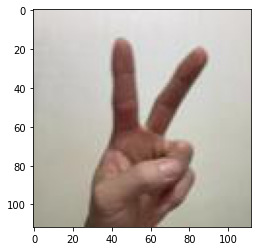

In [24]:
plt.imshow(x_full_train_f[0])
print('라벨: ', y_full_train_f[0])

In [25]:
from keras import models, layers, optimizers, utils
from keras.layers import Dropout

In [26]:
model2 =keras.models.Sequential()

model2.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(112,112,3)))
model2.add(keras.layers.MaxPool2D(2,2))

model2.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))

model2.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model2.layers))

model2.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 110, 110, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (

In [27]:
!free -mh

              total        used        free      shared  buff/cache   available
Mem:           17Gi       3.2Gi       9.3Gi        15Mi       5.1Gi        14Gi
Swap:            0B          0B          0B


모델 학습을 위해 하이퍼파라미터를 설정하고, data agumentation을 진행한후 학습데이터와 검증데이터를 나눈다.

In [28]:
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(x_full_train_f, y_full_train_f, test_size= 0.20, shuffle=True, random_state=1004)

In [29]:
# parameter Initialization
batch_size = 64
epochs = 100
IMG_HEIGHT = 112
IMG_WIDTH = 112

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.5,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [31]:
# image_dir_path_f = os.getenv("HOME") + "/aiffel/rock_scissor_paper/fixed" #윗쪽 코드블럭에 디렉토리를 지정해 두었다.

X_train_f_gen = image_gen_train.flow(X_train_f, y=y_train_f,  batch_size=batch_size,
                                                    shuffle=True)

In [32]:
X_train_f_gen[0][0].shape

(64, 112, 112, 3)

In [33]:
#데이터 시각화를 위한 함수 정의
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

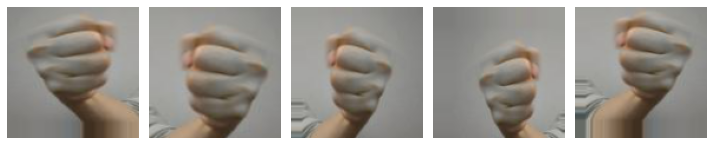

In [34]:
augmented_images = [X_train_f_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

데이터 증강이 이루어진 것을 확인했다. Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 변형하는 등의 조작은 하지 않고 스케일만 변경한다.

In [35]:
image_gen_val = ImageDataGenerator(rescale=1./255)

X_val_f_gen = image_gen_val.flow(X_val_f, y=y_val_f,  batch_size=batch_size,
                                                    shuffle=True)

In [36]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(optimizer=adam,        
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


history2 = model2.fit(
      X_train_f, y_train_f,epochs=epochs,
    validation_data=(X_val_f, y_val_f))

Epoch 1/100
34/34 [==============================] - 2s 32ms/step - loss: 10.4551 - accuracy: 0.4907 - val_loss: 0.5997 - val_accuracy: 0.7815
Epoch 2/100
34/34 [==============================] - 1s 18ms/step - loss: 0.5882 - accuracy: 0.7759 - val_loss: 0.3218 - val_accuracy: 0.8630
Epoch 3/100
34/34 [==============================] - 1s 18ms/step - loss: 0.2967 - accuracy: 0.8935 - val_loss: 0.2432 - val_accuracy: 0.9259
Epoch 4/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1725 - accuracy: 0.9426 - val_loss: 0.2199 - val_accuracy: 0.9370
Epoch 5/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0957 - accuracy: 0.9685 - val_loss: 0.2705 - val_accuracy: 0.9481
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0828 - accuracy: 0.9722 - val_loss: 0.2091 - val_accuracy: 0.9704
Epoch 7/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0909 - accuracy: 0.9731 - val_loss: 0.2009 - val_accuracy: 0.9667
Epoch

In [37]:
history2.history

{'loss': [10.455093383789062,
  0.5881865620613098,
  0.2966526448726654,
  0.1724606305360794,
  0.09574231505393982,
  0.08277315646409988,
  0.09091798961162567,
  0.06783287972211838,
  0.06767750531435013,
  0.07653119415044785,
  0.05434024706482887,
  0.09358621388673782,
  0.048336055129766464,
  0.030002227053046227,
  0.013249114155769348,
  0.015447847545146942,
  0.024933191016316414,
  0.04216928407549858,
  0.15425167977809906,
  0.04206281155347824,
  0.03488382697105408,
  0.041147131472826004,
  0.02272733673453331,
  0.034616973251104355,
  0.4449779987335205,
  0.34209102392196655,
  0.1379300355911255,
  0.057718876749277115,
  0.054420143365859985,
  0.019883763045072556,
  0.03138437494635582,
  0.02063489332795143,
  0.03416813164949417,
  0.019774911925196648,
  0.012239213101565838,
  0.02266172505915165,
  0.010565628297626972,
  0.0052360184490680695,
  0.004772328305989504,
  0.005746333859860897,
  0.008729668334126472,
  0.002250616205856204,
  0.005257521

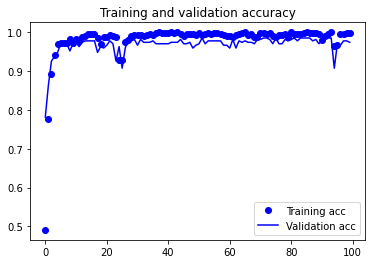

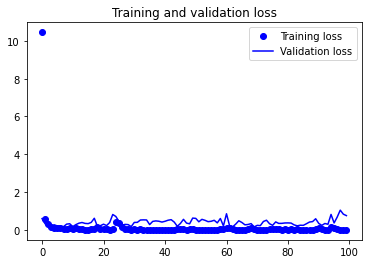

In [38]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range2 = range(len(acc2))

plt.plot(epochs_range2, acc2, 'bo', label='Training acc')
plt.plot(epochs_range2, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range2, loss2, 'bo', label='Training loss')
plt.plot(epochs_range2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
test_scissor_image_dir_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_112/scissor"
resize_images_112(test_scissor_image_dir_path2)   # 테스트 가위 이미지 resize
print("테스트용 가위 이미지 resize 완료!", '\n')

test_rock_image_dir_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_112/rock"
resize_images_112(test_rock_image_dir_path2)   # 테스트 바위 이미지 resize
print("테스트용 바위 이미지 resize 완료!", '\n')

test_paper_image_dir_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_112/paper"
resize_images_112(test_paper_image_dir_path2)   # 테스트 보 이미지 resize
print("테스트용 보 이미지 resize 완료!", '\n')

100  images to be resized.
100  images resized by 112*112.
테스트용 가위 이미지 resize 완료! 

100  images to be resized.
100  images resized by 112*112.
테스트용 바위 이미지 resize 완료! 

100  images to be resized.
100  images resized by 112*112.
테스트용 보 이미지 resize 완료! 



In [40]:
image_dir_path_f = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_112"

(x_test_f, y_test_f)=load_data_2(image_dir_path_f, 300)

print("x_test_f shape: {}".format(x_test_f.shape))
print("y_test_f shape: {}".format(y_test_f.shape))

이미지 개수는 300 입니다.
x_test_f shape: (300, 112, 112, 3)
y_test_f shape: (300,)


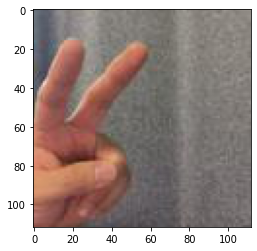

In [41]:
plt.imshow(x_test_f[0], cmap=plt.cm.binary)
plt.show()

테스트용 데이터가 준비되었으니, 위에서 훈련시킨 model을 사용하여 test_accuracy를 측정한다.

In [42]:
test_loss_f, test_accuracy_f = model2.evaluate(x_test_f, y_test_f, verbose = 2)

print("test_loss : {}".format(test_loss_f))
print("test_accuracy : {}".format(test_accuracy_f))

10/10 - 0s - loss: 1.4393 - accuracy: 0.6867
test_loss : 1.4392656087875366
test_accuracy : 0.6866666674613953


개선한 모델이 실제로 어떤 이미지를 어떻게 분류했는지 알아본다.

In [43]:
pred = model2.predict(x_test_f)  
pred_y = np.argmax(pred, axis=1)

예측확률분포: [0.45997092 0.5294325  0.01059669]
라벨: 0, 예측결과: 1


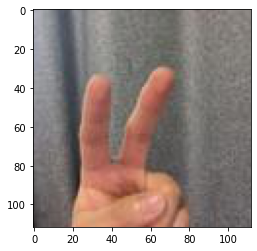

예측확률분포: [9.9516255e-01 2.0134441e-05 4.8172642e-03]
라벨: 2, 예측결과: 0


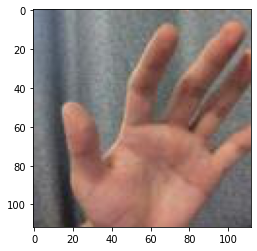

예측확률분포: [0.6880871  0.29056215 0.0213507 ]
라벨: 1, 예측결과: 0


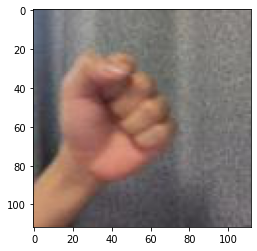

예측확률분포: [0.92935145 0.0326129  0.03803562]
라벨: 2, 예측결과: 0


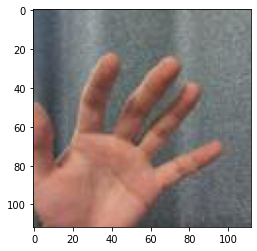

예측확률분포: [1.2410828e-04 9.9985504e-01 2.0883021e-05]
라벨: 0, 예측결과: 1


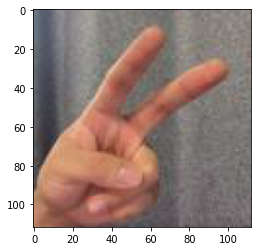

예측확률분포: [0.8848487  0.08623683 0.02891445]
라벨: 2, 예측결과: 0


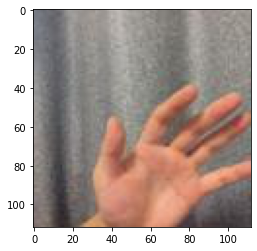

예측확률분포: [9.9988866e-01 4.6284008e-06 1.0673165e-04]
라벨: 2, 예측결과: 0


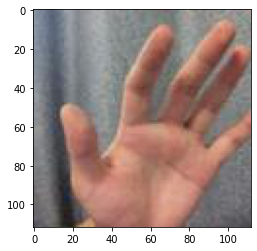

예측확률분포: [0.59308267 0.24623585 0.16068152]
라벨: 1, 예측결과: 0


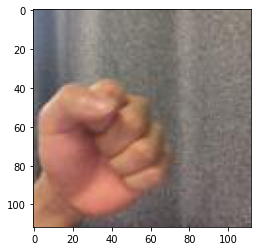

예측확률분포: [3.30399075e-06 9.89104807e-01 1.08918585e-02]
라벨: 0, 예측결과: 1


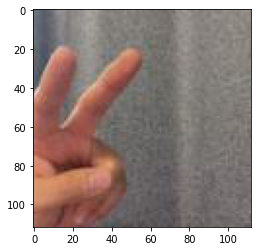

예측확률분포: [0.4370839  0.43192488 0.13099128]
라벨: 2, 예측결과: 0


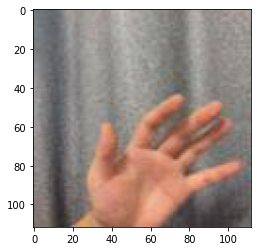

예측확률분포: [6.9320440e-01 7.0099712e-05 3.0672547e-01]
라벨: 2, 예측결과: 0


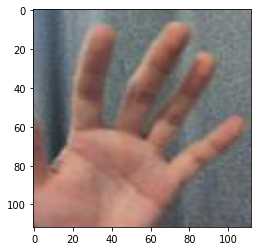

예측확률분포: [0.51948035 0.41116437 0.06935527]
라벨: 1, 예측결과: 0


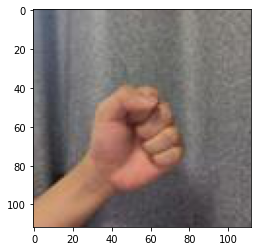

예측확률분포: [7.1946408e-07 9.9667335e-01 3.3259406e-03]
라벨: 0, 예측결과: 1


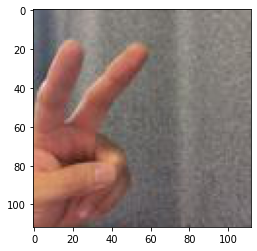

예측확률분포: [0.49342772 0.32363474 0.18293753]
라벨: 2, 예측결과: 0


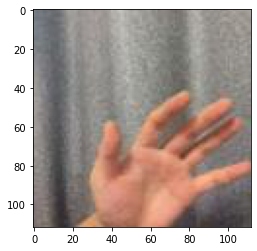

예측확률분포: [0.88355654 0.09161732 0.02482602]
라벨: 1, 예측결과: 0


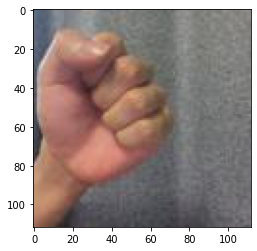

In [44]:
import random

wrong=[]

for i, _ in enumerate(pred_y):
        if pred_y[i] != y_test_f[i]:
            wrong.append(i)


samples = random.choices(population=wrong, k=15)

for n in samples:
    print("예측확률분포: " + str(pred[n]))
    print("라벨: " + str(y_test_f[n]) + ", 예측결과: " + str(pred_y[n]))
    plt.imshow(x_test_f[n], cmap=plt.cm.binary)
    plt.show()

처음 개선을 시도한 모델에서 여전히 정확도가 확보되지 않은 것은 여러번의 시도 끝에 학습 데이터셋의 문제라고 판단할 수 있었다. (모델의 구조적인 부분에서는 과대적합이 시작되는 기준으로 아주 많은 파라미터 변경 시도를 거침.)  
학습데이터를 엄선하여 다시 모델을 학습하고 테스트 데이터에 적용해 보았다.
학습한 모델의 일반적인 성능을 위해 테스트 데이터는 학습자료와 전혀 관계없는, 교재 제공 자료로 시도했다.

10/10 - 0s - loss: 1.4393 - accuracy: 0.6867  
test_loss : 1.4392656087875366  
test_accuracy : 0.6866666674613953    

마지막 정확도 68%로 마무리했다.

### Refereces

- 이미지 데이터 증강 방법 (https://keras.io/ko/preprocessing/image/)  
- 모델의 하이퍼 파라미터 설정 (https://inhovation97.tistory.com/32)  
